In [1]:
!pip install --upgrade pip

    100% |████████████████████████████████| 1.4MB 126.3MB/s ta 0:00:01
  Found existing installation: pip 9.0.1
    Uninstalling pip-9.0.1:
      Successfully uninstalled pip-9.0.1


In [2]:
!pip install -r ../requirements.txt

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 20.1MB 64.2MB/s eta 0:00:01K     |▌                               | 307kB 64.2MB/s eta 0:00:01�█▎                       | 5.2MB 64.2MB/s eta 0:00:01�████████████▉                | 10.0MB 64.2MB/s eta 0:00:01.9MB 64.2MB/s eta 0:00:01��████████████████████▉  | 18.8MB 64.2MB/s eta 0:00:01
     |████████████████████████████████| 2.1MB 69.3MB/s eta 0:00:01
     |████████████████████████████████| 2.9MB 28.4MB/s eta 0:00:01
     |████████████████████████████████| 61kB 69.2MB/s eta 0:00:01
  Found existing installation: numpy 1.14.0
    Uninstalling numpy-1.14.0:
      Successfully uninstalled numpy-1.14.0
  Found existing installation: Pillow 5.0.0
    Uninstalling Pillow-5.0.0:
      Successfully uninstalled Pillow-5.0.0
  Found existing installation: h5py 2.7.1
    Uninstalling h5py-2.7.1:
      Successfully uninstalled h5py-2.7.1


In [3]:
!pip install torch

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 734.6MB 12.1MB/s eta 0:00:014 | 3.3MB 22.2MB/s eta 0:00:33                    | 8.3MB 22.2MB/s eta 0:00:33 | 12.7MB 22.2MB/s eta 0:00:33B/s eta 0:00:33                | 21.5MB 22.2MB/s eta 0:00:33.4MB 22.2MB/s eta 0:00:32.4MB 22.2MB/s eta 0:00:320:31310:31310:300:30�                            | 78.8MB 22.2MB/s eta 0:00:30                         | 84.1MB 22.2MB/s eta 0:00:30                         | 88.3MB 96.8MB/s eta 0:00:07    | 93.1MB 96.8MB/s eta 0:00:07.0MB 96.8MB/s eta 0:00:07                    | 102.5MB 96.8MB/s eta 0:00:07.8MB/s eta 0:00:07��██▉                           | 111.4MB 96.8MB/s eta 0:00:07��███                           | 115.8MB 96.8MB/s eta 0:00:07��█▎                          | 120.1MB 96.8MB/s eta 0:00:07                  | 124.9MB 96.8MB/s eta 0:00:07��█▋                          | 129.5MB 96.8MB/s eta 0:00:07     |█████▉                         

In [4]:
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import PIL.Image as pil_image

from models import RDN

import pandas as pd
import os

from utils import convert_rgb_to_y, denormalize, calc_psnr

In [5]:
def test(weights_file, image_file, num_features=64, growth_rate=64, num_blocks=16, num_layers=8, scale=4):
    cudnn.benchmark = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model = RDN(scale_factor=scale,
                num_channels=3,
                num_features=num_features,
                growth_rate=growth_rate,
                num_blocks=num_blocks,
                num_layers=num_layers).to(device)

    state_dict = model.state_dict()
    for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
        if n in state_dict.keys():
            state_dict[n].copy_(p)
        else:
            raise KeyError(n)

    model.eval()

    image = pil_image.open(image_file).convert('RGB')

    image_width = (image.width // scale) * scale
    image_height = (image.height // scale) * scale

    hr = image.resize((image_width, image_height), resample=pil_image.BICUBIC)
    lr = hr.resize((hr.width // scale, hr.height // scale), resample=pil_image.BICUBIC)
    bicubic = lr.resize((lr.width * scale, lr.height * scale), resample=pil_image.BICUBIC)
    bicubic.save(image_file.replace('.png', '_bicubic_x{}.png'.format(scale)))

    lr = np.expand_dims(np.array(lr).astype(np.float32).transpose([2, 0, 1]), 0) / 255.0
    hr = np.expand_dims(np.array(hr).astype(np.float32).transpose([2, 0, 1]), 0) / 255.0
    lr = torch.from_numpy(lr).to(device)
    hr = torch.from_numpy(hr).to(device)

    with torch.no_grad():
        preds = model(lr).squeeze(0)

    preds_y = convert_rgb_to_y(denormalize(preds), dim_order='chw')
    hr_y = convert_rgb_to_y(denormalize(hr.squeeze(0)), dim_order='chw')

    preds_y = preds_y[scale:-scale, scale:-scale]
    hr_y = hr_y[scale:-scale, scale:-scale]

    psnr = calc_psnr(hr_y, preds_y)
#     print('PSNR: {:.2f}'.format(psnr))

    output = pil_image.fromarray(denormalize(preds).permute(1, 2, 0).byte().cpu().numpy())
    output.save(image_file.replace('.png', '_rdn_x{}.png'.format(scale)))
    
    return {
        "test_set" : image_file.split("/")[1],
        "psnr" : psnr.item()
    }

In [6]:
models_dir = "../rdn-results/outputs/x4/"
images_dir = ["../BSDS100/", "../Set5/", "../Set14/", "../Urban100/"]

In [7]:
test_images = {}
for test_dir in images_dir:
    f = []
    for (dirpath, dirnames, filenames) in os.walk(test_dir):
        f.extend(filenames)
        break
    test_images[test_dir.split("/")[1]] = f

In [8]:
five_up = {}
for i in test_images.keys():
    five_up[i] = test_images[i][:5]

In [9]:
pd.DataFrame(five_up)

,BSDS100,Set14,Set5,Urban100
0,300091_rdn_x4.png,pepper.png,bird.png,img_009_bicubic_x4.png
1,19021.png,monarch_bicubic_x4.png,woman_rdn_x4.png,img_063.png
2,208001_bicubic_x4.png,lenna_bicubic_x4.png,head.png,img_098.png
3,87046_rdn_x4.png,man.png,butterfly_rdn_x4.png,img_008.png
4,108082_rdn_x4.png,baboon_bicubic_x4.png,head_rdn_x4.png,img_086.png


In [10]:
### get best model 
log_name = "base.log"
train_log = open("../rdn-results/logs/" + log_name)
k = 0
train_log_arr = []
for i in train_log.read().split("\n"):
    if i:
        train_log_arr.append((k, float(i.split(":")[1])))
        k+=1

train_log_arr_sorted = sorted(train_log_arr, reverse=True, key=lambda x: x[1])

In [11]:
best_epoch = train_log_arr_sorted[0][0]
best_epoch

389

In [12]:
# display learning chart 

In [13]:
def create_dict_from_train_log(arr):
   
    return {"eval psnr": float(arr[1])}
    

In [14]:
def process_train_loss_line(line):
    loss_arr = line.split("[")[-1].split(", ")[-1].replace("]", "").split("=")
    epoch = line.split(":")[1].split("/")[0]
    
    return {"epoch" : epoch, loss_arr[0] : float(loss_arr[1])}
    
    

### parse the training log copied from std output during training 

In [15]:
train_log_loss = open("../rdn-results/logs/train-loss.log")
train_log_loss_arr = [process_train_loss_line(i) for i in train_log_loss.read().split("\n") if "epoch" in i]
df_train_loss = pd.DataFrame(train_log_loss_arr)
df_train_loss.head()

,epoch,loss
0,0,0.068386
1,1,0.035733
2,2,0.033469
3,3,0.031551
4,4,0.031076


In [16]:
df_train_loss["loss"].plot(figsize=(15, 5))

In [17]:
train_log_dicts = [ create_dict_from_train_log(i) for i in train_log_arr[:-1]]

In [18]:
train_df = pd.DataFrame(train_log_dicts)
train_df.head()

,eval psnr
0,28.01
1,28.84
2,29.03
3,29.09
4,28.99


### progression of psnr across epochs

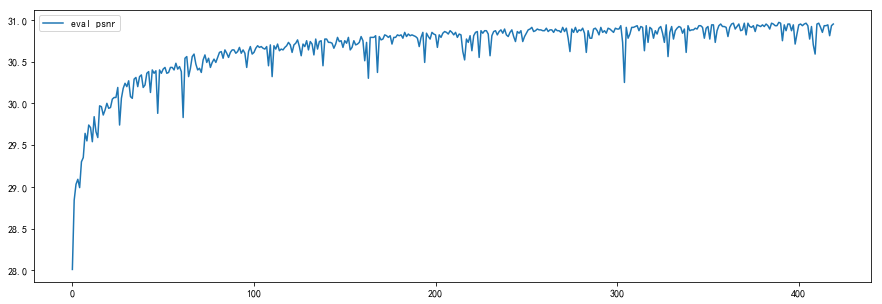

In [19]:
train_df.plot(figsize=(15, 5))

In [20]:
weights_file = models_dir + "best.pth"

if not os.path.isfile(weights_file):
    weights_file = models_dir + "epoch_{}.pth".format(best_epoch)

os.path.isfile(weights_file), weights_file

(True, '../rdn-results/outputs/x4/epoch_389.pth')

In [21]:
test_results = []
if os.path.isfile(weights_file):
    for key in test_images.keys():
        max_images = 0
        print ("testing " + key)
        for image in test_images[key]:
            if not ("_rdn_x4" in image or "_bicubic_x" in image):
                image_file = "../" + key + "/" + image
                test_results.append(test(weights_file, image_file))
                max_images += 1
            

testing BSDS100
testing Set5
testing Set14
testing Urban100


In [22]:
def get_test_report(array_of_dicts, dataset):
    this_arr = [i for i in array_of_dicts if dataset == i["test_set"] ]
    return pd.DataFrame(this_arr)

In [23]:
import json 

with open("../rdn-results/logs/test-results.json", mode='w', encoding='utf-8') as f:
    json.dump(test_results, f)


In [24]:
stats_BSDS100 = get_test_report(test_results, "BSDS100")

In [25]:
stats_BSDS100["psnr"].describe()

count    100.000000
mean      28.554810
std        3.827777
min       21.135981
25%       25.967616
50%       28.140200
75%       30.540191
max       41.205368
Name: psnr, dtype: float64

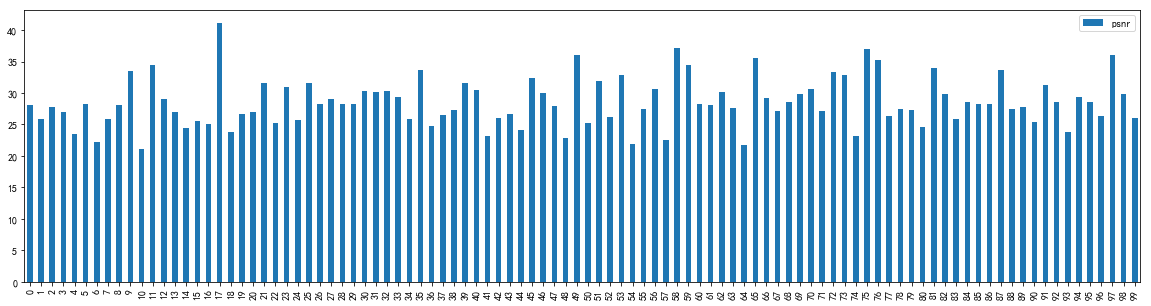

In [26]:
stats_BSDS100.plot.bar(figsize=(20,5))

In [27]:
stats_Set5 = get_test_report(test_results, "Set5")
stats_Set5.describe()

,psnr
count,5.000000
mean,32.241211
std,2.623678
min,28.590965
25%,30.622101
50%,33.019463
75%,33.816597
max,35.156929


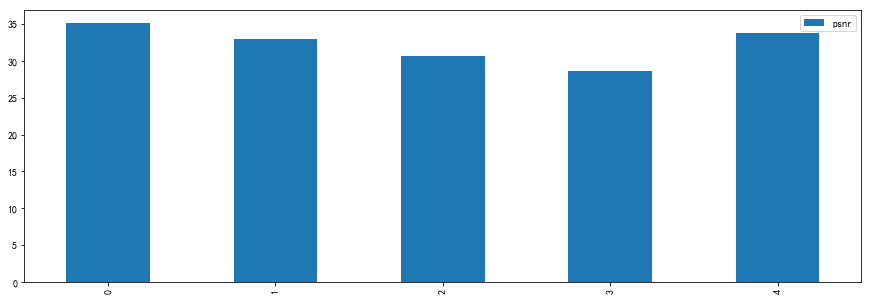

In [28]:
stats_Set5.plot.bar(figsize = (15,5))

In [29]:
stats_Set14 = get_test_report(test_results, "Set14")
stats_Set14.describe()

,psnr
count,14.000000
mean,28.784768
std,3.846499
min,23.047039
25%,26.104673
50%,27.716413
75%,32.864927
max,34.389767


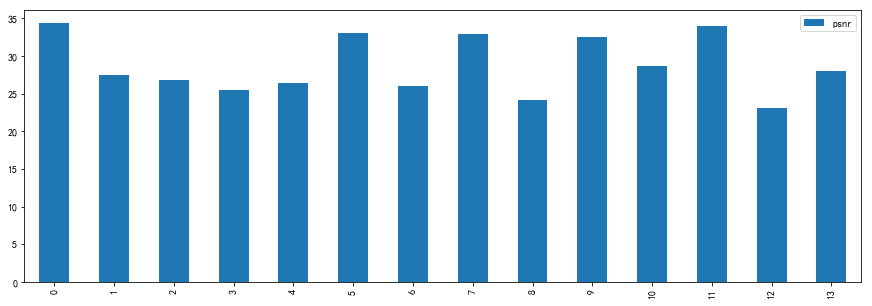

In [30]:
stats_Set14.plot.bar(figsize = (15,5))

In [31]:
stats_Urban100 = get_test_report(test_results, "Urban100")
stats_Urban100.describe()

,psnr
count,100.000000
mean,26.116822
std,4.129834
min,17.743006
25%,22.670436
50%,26.207972
75%,28.585055
max,38.439369


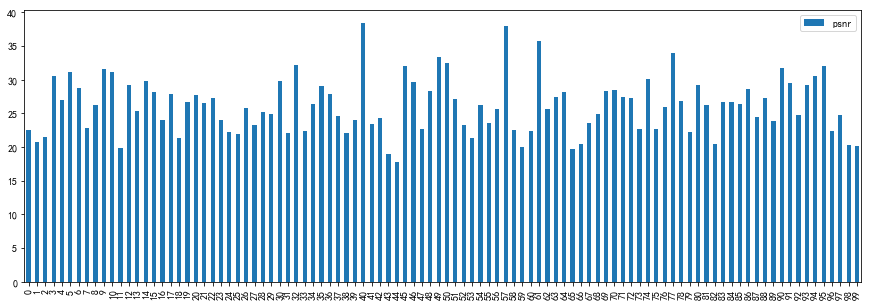

In [32]:
stats_Urban100.plot.bar(figsize = (15,5))

In [ ]:
!git status